In [3]:
from lib.geocoder.our_geocoder import Geocoder
import matplotlib.pyplot as plt
import geopandas as gpd

In [4]:
g = Geocoder("outputs/FR_MODEL_2/nside_512/FR_nside_512/FR_nside_512_4_100_A_I_P.h5.part","outputs/FR_MODEL_2/nside_512/FR_nside_512/FR_nside_512_4_100_A_I_P_index")

In [5]:
toponyms = "Paris;Cherbourg;Saint-Lô;Caen;Lyon;Rennes;Montpellier;Occitanie;Toulouse;Pau".split(";")

In [6]:
from lib.geocoder.heuristics import *

In [7]:
res_heuristic = heuristic_no_context(g,toponyms)
res_heuristic

{'Paris': {'lat': 48.891907, 'lon': 2.3173065},
 'Cherbourg': {'lat': 49.09114, 'lon': -1.1740417},
 'Saint-Lô': {'lat': 48.602127, 'lon': -0.73223877},
 'Caen': {'lat': 48.751816, 'lon': 0.055923462},
 'Lyon': {'lat': 45.72853, 'lon': 4.729294},
 'Rennes': {'lat': 48.395355, 'lon': -1.3266144},
 'Montpellier': {'lat': 43.52542, 'lon': 2.7322083},
 'Occitanie': {'lat': 43.17047, 'lon': 1.231308},
 'Toulouse': {'lat': 43.70291, 'lon': 1.5109406},
 'Pau': {'lat': 44.439102, 'lon': 1.7921295}}

(40.0, 55.0)

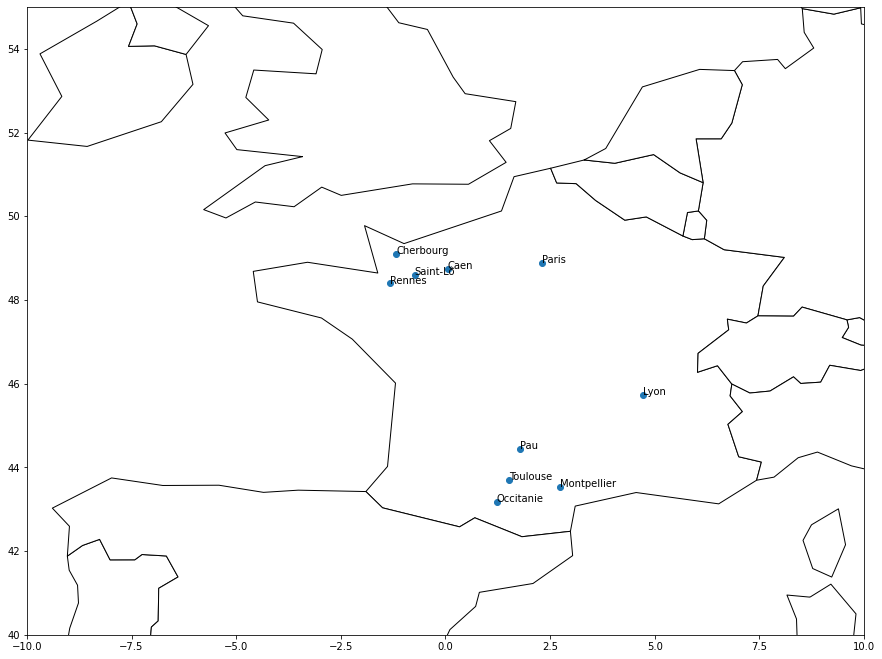

In [8]:
from shapely.geometry import Point
df_point = pd.DataFrame.from_dict(res_heuristic,orient="index")
df_point["geometry"] = df_point.apply(lambda x:Point(x.lon,x.lat),axis=1)
fig, ax = plt.subplots(1,figsize=(15,15))
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world.plot(color='white', edgecolor='black',ax=ax)
gpd.GeoDataFrame(df_point).plot(ax=ax)
for tp,coord in res_heuristic.items(): 
    ax.annotate(tp,(coord["lon"],coord["lat"]))
ax.set_xlim((-10,10))
ax.set_ylim((40,55))

In [9]:
input_ = np.asarray([[t1,t2] for t2 in toponyms for t1 in toponyms if t2 != t1])
res_geocode = pd.DataFrame(input_,columns="t tc".split())
lons,lats = g.get_coords(input_[:,0],input_[:,1])
res_geocode["lon"] = lons
res_geocode["lat"] = lats


from shapely.geometry import Point
import folium
m = folium.Map()
for ix,row in res_geocode.iterrows(): 
    ax.annotate(row.t + " " + row.tc,(row["lon"],row["lat"]))
    folium.Marker([row.lat, row.lon], popup=row.t + " " + row.tc).add_to(m)
    
m

In [10]:
g.plot_coord??

Signature: g.plot_coord(toponym, lat, lon, interactive_map=False, **kwargs)
Docstring: <no docstring>
Source:   
    def plot_coord(self,toponym,lat,lon,interactive_map=False,**kwargs):
        if interactive_map:
            import folium
            import tempfile
            import webbrowser
            fp = tempfile.NamedTemporaryFile(delete=False)
            m = folium.Map()
            folium.Marker([lat, lon], popup=toponym).add_to(m)
            m.save(fp.name)
            webbrowser.open('file://' + fp.name)
        else:
            import matplotlib.pyplot as plt
            import geopandas
            fig, ax = plt.subplots(1,**kwargs)
            world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
            world.plot(color='white', edgecolor='black',ax=ax)
            ax.plot(lon,lat,marker='o', color='red', markersize=5)
            plt.show()
File:      ~/POSTDOCLYON/toponym-geocoding/lib/geocoder/our_geocoder.py
Type:      method


In [11]:


from lib.utils_geo import haversine_pd
from sklearn.cluster import DBSCAN
from sklearn.metrics.pairwise import haversine_distances

In [12]:
res_geocode["lon lat".split()].values.shape

(90, 2)

In [13]:
from haversine import haversine_vector, Unit

In [14]:
haversine_vector(res_geocode["lon lat".split()].values,res_geocode["lon lat".split()].values,unit="km",comb=True)

array([[  0.      ,  74.38099 ,  31.865028, ..., 670.45294 , 644.2007  ,
        613.9308  ],
       [ 74.38099 ,   0.      , 102.8423  , ..., 625.586   , 622.1915  ,
        581.8792  ],
       [ 31.865028, 102.8423  ,   0.      , ..., 675.55005 , 638.657   ,
        613.02527 ],
       ...,
       [670.45294 , 625.586   , 675.55005 , ...,   0.      , 221.29712 ,
        134.94882 ],
       [644.2007  , 622.1915  , 638.657   , ..., 221.29712 ,   0.      ,
         95.80514 ],
       [613.9308  , 581.8792  , 613.02527 , ..., 134.94882 ,  95.80514 ,
          0.      ]], dtype=float32)

In [15]:

from haversine import haversine_vector, Unit
def heuristic_cluster(geocoder,toponyms,eps=100):
    results = {}
    input_ = np.asarray([[t1,t2] for t2 in toponyms for t1 in toponyms if t2 != t1])
    res_geocode = pd.DataFrame(input_,columns="t tc".split())
    lons,lats = geocoder.get_coords(input_[:,0],input_[:,1])
    res_geocode["lon"] = lons
    res_geocode["lat"] = lats

    clf = DBSCAN(eps=eps)
    for t in toponyms:
        tp_df = res_geocode[res_geocode.tc == t].copy()

        coords = tp_df["lon lat".split()].values
        clf.fit(haversine_vector(coords,coords,unit="km",comb=True))

        tp_df["cluster"] = clf.labels_
        counts_ = dict(tp_df.cluster.value_counts())
        max_cluster = max(counts_, key=counts_.get)
        tp_df = tp_df[tp_df.cluster == max_cluster]
        lat = tp_df.lat.median()
        lon = tp_df.lon.median() #
        results[t]={"lat":lat,"lon":lon}
    return results

results = heuristic_cluster(g,toponyms)
    
results


{'Paris': {'lat': 48.510147, 'lon': 0.8369751},
 'Cherbourg': {'lat': 47.15422, 'lon': -0.20059204},
 'Saint-Lô': {'lat': 47.375473, 'lon': 0.21366882},
 'Caen': {'lat': 48.834396, 'lon': 0.093063354},
 'Lyon': {'lat': 45.77159, 'lon': 3.4461823},
 'Rennes': {'lat': 46.499756, 'lon': -0.51908875},
 'Montpellier': {'lat': 43.609375, 'lon': 1.9396667},
 'Occitanie': {'lat': 43.59912, 'lon': 0.7354431},
 'Toulouse': {'lat': 43.70291, 'lon': 1.5823364},
 'Pau': {'lat': 46.071503, 'lon': 0.79255676}}

(30.0, 55.0)

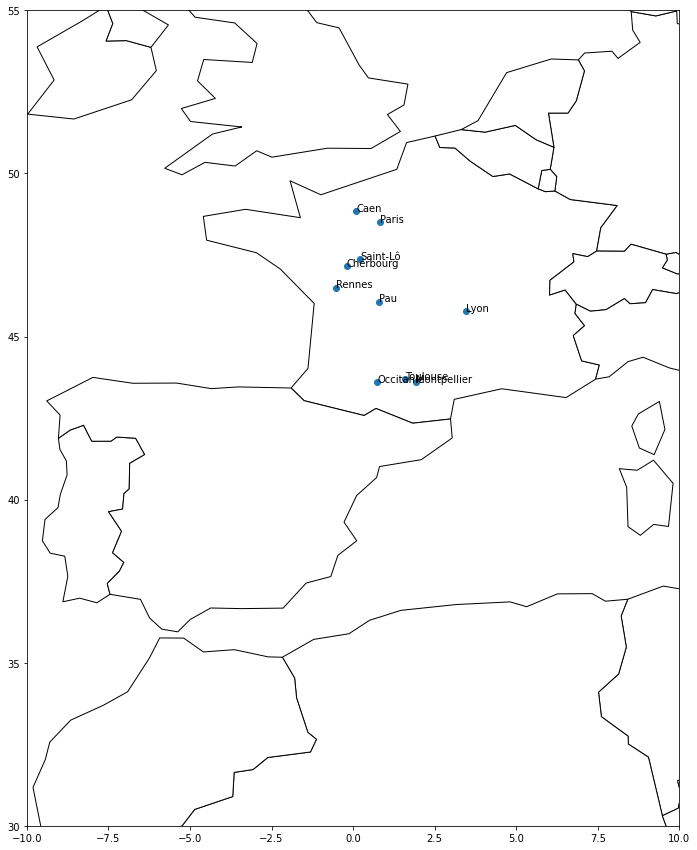

In [16]:
from shapely.geometry import Point
df_point = pd.DataFrame.from_dict(results,orient="index")
df_point["geometry"] = df_point.apply(lambda x:Point(x.lon,x.lat),axis=1)
fig, ax = plt.subplots(1,figsize=(15,15))
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world.plot(color='white', edgecolor='black',ax=ax)
gpd.GeoDataFrame(df_point).plot(ax=ax)
for tp,coord in results.items(): 
    ax.annotate(tp,(coord["lon"],coord["lat"]))
ax.set_xlim((-10,10))
ax.set_ylim((30,55))